### Q.7. Implement Support Vector Machine algorithm for classification and regression in a given business environment and evaluate the performances.
#### a. Import a regression based dataset, implement SVM algorithm for regression, and apply algorithm on the dataset.
#### b. Import a classification based dataset, implement SVM algorithm for classification, and apply algorithm on the dataset
#### c. Evaluate the performance of model on validation and testing dataset. 

### Dataset
The experiments have been carried out with a group of 30 volunteers within an age bracket of 19-48 years. Each person performed six activities (WALKING, WALKINGUPSTAIRS, WALKINGDOWNSTAIRS, SITTING, STANDING, LAYING) wearing a smartphone (Samsung Galaxy S II) on the waist. Using its embedded accelerometer and gyroscope, we captured 3-axial linear acceleration and 3-axial angular velocity at a constant rate of 50Hz. The experiments have been video-recorded to label the data manually. The obtained dataset has been randomly partitioned into two sets, where 70% of the volunteers was selected for generating the training data and 30% the test data.

In [1]:
import numpy as np
import pylab as pl
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV

In [2]:
train = shuffle(pd.read_csv("train.csv"))
test = shuffle(pd.read_csv("test.csv"))

In [3]:
print("Any missing sample in training set:",train.isnull().values.any())
print("Any missing sample in test set:",test.isnull().values.any(), "\n")

Any missing sample in training set: False
Any missing sample in test set: False 



In [4]:
train_outcome = pd.crosstab(index=train["Activity"],  # Make a crosstab
                              columns="count")      # Name the count column

train_outcome

col_0,count
Activity,
LAYING,1407
SITTING,1286
STANDING,1374
WALKING,1226
WALKING_DOWNSTAIRS,986
WALKING_UPSTAIRS,1073


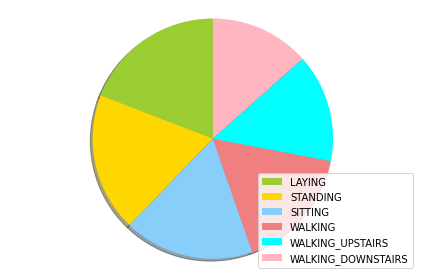

In [5]:
# Visualizing Outcome Distribution 
temp = train["Activity"].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })

#df.plot(kind='pie',labels='labels',values='values', title='Activity Ditribution',subplots= "True")

labels = df['labels']
sizes = df['values']
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral','cyan','lightpink']
patches, texts = plt.pie(sizes, colors=colors, shadow=True, startangle=90, pctdistance=1.1, labeldistance=1.2)
plt.legend(patches, labels, loc="best")
plt.axis('equal')
plt.tight_layout()
plt.show()

In [6]:
# Seperating Predictors and Outcome values from train and test sets
X_train = pd.DataFrame(train.drop(['Activity','subject'],axis=1))
Y_train_label = train.Activity.values.astype(object)
X_test = pd.DataFrame(test.drop(['Activity','subject'],axis=1))
Y_test_label = test.Activity.values.astype(object)

# Dimension of Train and Test set 
print("Dimension of Train set",X_train.shape)
print("Dimension of Test set",X_test.shape,"\n")

# Transforming non numerical labels into numerical labels
from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()

# encoding train labels 
encoder.fit(Y_train_label)
Y_train = encoder.transform(Y_train_label)

# encoding test labels 
encoder.fit(Y_test_label)
Y_test = encoder.transform(Y_test_label)

#Total Number of Continous and Categorical features in the training set
num_cols = X_train._get_numeric_data().columns
print("Number of numeric features:",num_cols.size)
#list(set(X_train.columns) - set(num_cols))


names_of_predictors = list(X_train.columns.values)

# Scaling the Train and Test feature set 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Dimension of Train set (7352, 561)
Dimension of Test set (2947, 561) 

Number of numeric features: 561


In [7]:
#Libraries to Build Ensemble Model : Random Forest Classifier 
# Create the parameter grid based on the results of random search 
params_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

In [8]:
# Performing CV to tune parameters for best SVM fit 
svm_model = GridSearchCV(SVC(), params_grid, cv=5)
svm_model.fit(X_train_scaled, Y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']}])

In [9]:
# View the accuracy score
print('Best score for training data:', svm_model.best_score_,"\n") 

# View the best parameters for the model found using grid search
print('Best C:',svm_model.best_estimator_.C,"\n") 
print('Best Kernel:',svm_model.best_estimator_.kernel,"\n")
print('Best Gamma:',svm_model.best_estimator_.gamma,"\n")

final_model = svm_model.best_estimator_
Y_pred = final_model.predict(X_test_scaled)
Y_pred_label = list(encoder.inverse_transform(Y_pred))

Best score for training data: 0.9876229322456378 

Best C: 100 

Best Kernel: rbf 

Best Gamma: 0.001 



In [10]:
# Making the Confusion Matrix
#print(pd.crosstab(Y_test_label, Y_pred_label, rownames=['Actual Activity'], colnames=['Predicted Activity']))
print(confusion_matrix(Y_test_label,Y_pred_label))
print("\n")
print(classification_report(Y_test_label,Y_pred_label))

print("Training set score for SVM: %f" % final_model.score(X_train_scaled , Y_train))
print("Testing  set score for SVM: %f" % final_model.score(X_test_scaled  , Y_test ))

svm_model.score

[[537   0   0   0   0   0]
 [  3 440  47   0   0   1]
 [  0  13 519   0   0   0]
 [  0   0   0 486   4   6]
 [  0   0   0   6 389  25]
 [  0   0   0  15   2 454]]


                    precision    recall  f1-score   support

            LAYING       0.99      1.00      1.00       537
           SITTING       0.97      0.90      0.93       491
          STANDING       0.92      0.98      0.95       532
           WALKING       0.96      0.98      0.97       496
WALKING_DOWNSTAIRS       0.98      0.93      0.95       420
  WALKING_UPSTAIRS       0.93      0.96      0.95       471

          accuracy                           0.96      2947
         macro avg       0.96      0.96      0.96      2947
      weighted avg       0.96      0.96      0.96      2947

Training set score for SVM: 1.000000
Testing  set score for SVM: 0.958602


<bound method BaseSearchCV.score of GridSearchCV(cv=5, estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']}])>

SVM FOR REGRESSION

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [12]:
dataset = pd.read_csv('Position_Salaries.csv')
X = dataset.iloc[:, 1:2].values
y = dataset.iloc[:, 2].values

In [16]:
from sklearn.preprocessing import StandardScaler
X=X.reshape(-1, 1)
y=y.reshape(-1, 1)
sc_X = StandardScaler()
sc_y = StandardScaler()

X = sc_X.fit_transform(X)
y = sc_y.fit_transform(y)

In [17]:
from sklearn.svm import SVR
regressor = SVR(kernel = 'rbf')
regressor.fit(X, y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


SVR()

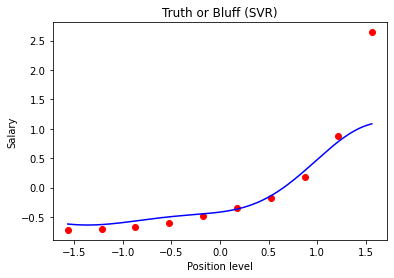

In [19]:

X_grid = np.arange(min(X), max(X), 0.01) #this step required because data is feature scaled.
X_grid = X_grid.reshape((len(X_grid), 1))
plt.scatter(X, y, color = 'red')
plt.plot(X_grid, regressor.predict(X_grid), color = 'blue')
plt.title('Truth or Bluff (SVR)')
plt.xlabel('Position level')
plt.ylabel('Salary')
plt.show()